# Customer Segementation project using RFM analysis

### This notebook contains online retail history transaction clean data from e-commerce platform
The goal of this project is to segment the customers into distinct groups of individuals that have similar characteristics

#### Part 1 : Query the Cleaned data 
- Explore online_transaction_cleaned data
- Data extraction 
- Connecting to Redshift
#### Part 2 : Exploratory analysis & Visualization
- Using SQL query
- Barplot Top 10 countries
- Barplot Top 10 customers as per average spending value
#### Part 3 : Transforming Data
- RFM analysis
- Derivation of RFM score
- Customer Segmentation using RFM score
- Value segment & Viz
- Describe RFM customer segment
#### Part 4 : Data Visualization
- Barplot value segments
- Plotly treemap RFM segment analysis
- Heatmap
- Piechart
- Co-relation matrix
- Plotly go bar chart comparison customer segment with RFM score


### Import Libraries

In [1]:
import os
import sys

import psycopg2
import pandas as pd
import numpy as np
from dotenv import load_dotenv
load_dotenv()  # To read the variables from .env file

# To import the definiations from python scripts from src folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.extract import extract_transactional_data
from src.extract import extract_customer_data
from src.transform import calculate_rfm_and_segment
from IPython.display import Image   

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import plotly.colors


# To remove warnings
import warnings
warnings.filterwarnings("ignore")

### To read variables from .env file

In [2]:
dbname= os.getenv('dbname')
host=os.getenv('host')
port=os.getenv('port')
user=os.getenv('user')
password=os.getenv('password')

### Redshift connection

In [3]:
def connect_to_redshift(dbname, host, port, user, password):
    """Method that connects to redshift. This gives a warning so will look for another solution"""

    connect = psycopg2.connect(
        dbname=dbname, host=host, port=port, user=user, password=password
    )
    print("connection to redshift made")

    return connect

In [4]:
connect = psycopg2.connect(dbname=dbname, host=host, port=port, user=user,password=password)

In [5]:
online_transactions_cleaned =extract_transactional_data(dbname, host, port, user, password)

connection to redshift made


In [6]:
online_transactions_cleaned.shape

(399841, 9)

In [7]:
online_transactions_cleaned.columns

Index(['invoice', 'stock_code', 'description', 'price', 'quantity',
       'total_order_value', 'invoice_date', 'customer_id', 'country'],
      dtype='object')

In [8]:
online_transactions_cleaned.head(10)

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country
0,536384,22189,CREAM HEART CARD HOLDER,3.95,4,15.80,2010-12-01 09:53:00,u18074,United Kingdom
1,536392,21891,TRADITIONAL WOODEN SKIPPING ROPE,1.25,12,15.00,2010-12-01 10:29:00,u13705,United Kingdom
2,536401,22068,BLACK PIRATE TREASURE CHEST,1.65,2,3.30,2010-12-01 11:21:00,u15862,United Kingdom
3,536412,22961,JAM MAKING SET PRINTED,1.45,24,34.80,2010-12-01 11:49:00,u1792,United Kingdom
4,536420,21889,WOODEN BOX OF DOMINOES,1.25,12,15.00,2010-12-01 12:03:00,u16583,United Kingdom
5,536464,22742,MAKE YOUR OWN PLAYTIME CARD KIT,2.95,1,2.95,2010-12-01 12:23:00,u17968,United Kingdom
6,536520,22557,PLASTERS IN TIN VINTAGE PAISLEY,1.65,2,3.30,2010-12-01 12:43:00,u14729,United Kingdom
7,536525,20973,12 PENCIL SMALL TUBE WOODLAND,0.65,2,1.30,2010-12-01 12:54:00,u14078,United Kingdom
8,536378,84519A,TOMATO CHARLIE+LOLA COASTER SET,2.95,6,17.70,2010-12-01 09:37:00,u14688,United Kingdom
9,536401,22100,SKULLS SQUARE TISSUE BOX,1.25,2,2.50,2010-12-01 11:21:00,u15862,United Kingdom


# Exploratory analysis using SQL & Data Viz


##### What are the top ten most popular geographical locations?
-  Extract SQL query to find out which country is most pouplar in spending 

In [9]:
query='''
select country,
       count(distinct customer_id) as customer_count
from bootcamp.online_transactions_cleaned
group by country
order by customer_count desc
limit 10;
'''
pd.read_sql(query,connect)

,country,customer_count
0,United Kingdom,3943
1,Germany,95
2,France,87
3,Spain,30
4,Belgium,25
5,Switzerland,21
6,Portugal,19
7,Italy,14
8,Finland,12
9,Austria,11


##### 90% customers who spends mostly are from United Kingdom

- Plot Top 10 countries using value_counts

In [10]:
online_transactions_cleaned.country.value_counts().head(10)
# Assigned variable
geo_location= online_transactions_cleaned.country.value_counts().head(10)
geo_location

country
United Kingdom    356158
Germany             9081
France              8154
EIRE                7469
Spain               2463
Netherlands         2330
Belgium             1971
Switzerland         1844
Portugal            1427
Australia           1256
Name: count, dtype: int64

##### Visualization plot of top 10 geopgraphic locations

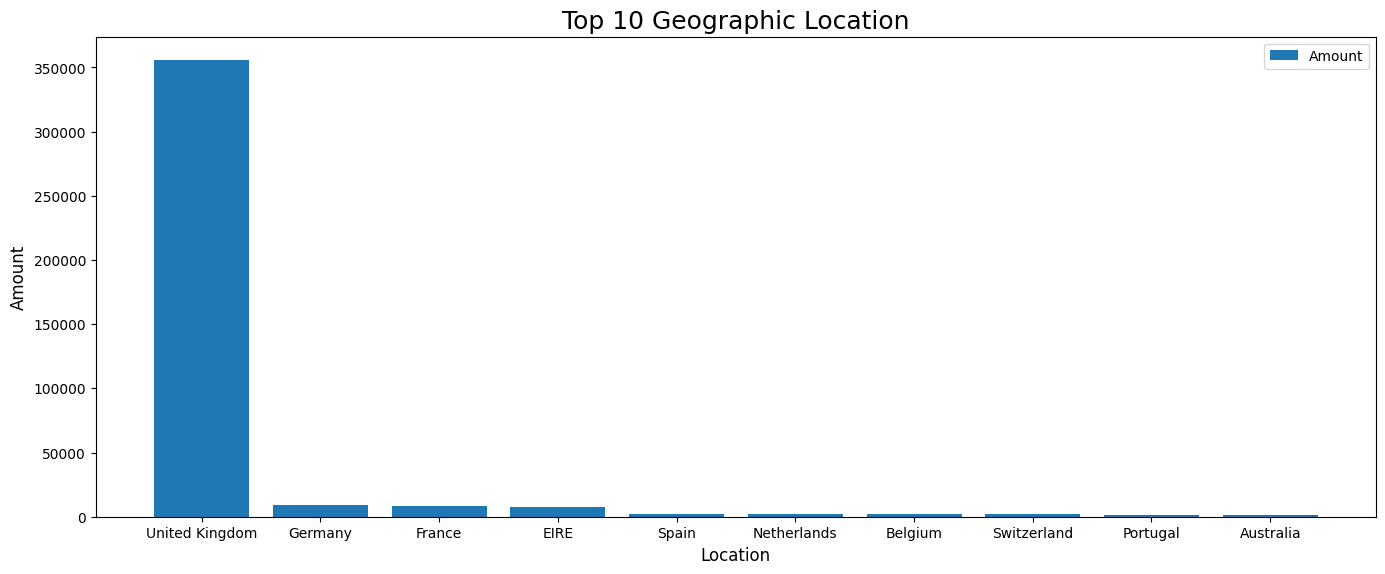

In [11]:
# Assigned variable name
top_10_geographic_location= geo_location.sort_values(ascending = False).head(10)

fig = plt.figure()
ax = fig.add_axes([0,0,2,1]) # [x0, y0, width, height] -> Change width & height 
ax.bar(top_10_geographic_location.index, top_10_geographic_location)

#ADD LEGEND
ax.legend(labels=['Amount'])

# ADDED LABELS
ax.set_title('Top 10 Geographic Location', fontweight ='medium', fontsize = 18)
ax.set_ylabel('Amount', fontsize = 12)
ax.set_xlabel('Location', fontsize = 12)

fig.show()

#### Above plot displays United Kingdom is the most popular among other locations

##### Which country spends the most (you can look at price, quantity or order value i.e. price * quantity)?
- Extract SQL query to understnad which country spends most looking at average spending 

In [12]:
query='''
select country,
       customer_id,
       avg(total_order_value) as average_spending
from bootcamp.online_transactions_cleaned
group by country,customer_id
order by average_spending desc
limit 5;
'''
pd.read_sql(query,connect)

,country,customer_id,average_spending
0,United Kingdom,u15098,9904.875000
1,United Kingdom,u15195,3861.000000
2,United Kingdom,u13135,3096.000000
3,United Kingdom,u16532,1687.200000
4,United Kingdom,u15749,1435.726667


#### United Kingdom is the highest country in terms of average spending pattern of customers

- Plot to find customers from which country spends more often

In [13]:
customer_spend=online_transactions_cleaned.groupby(['customer_id','country'])['total_order_value'].mean().sort_values(ascending=False).reset_index(name='avg_spend')
customer_spend.head()

,customer_id,country,avg_spend
0,u15098,United Kingdom,9904.875000
1,u15195,United Kingdom,3861.000000
2,u13135,United Kingdom,3096.000000
3,u16532,United Kingdom,1687.200000
4,u15749,United Kingdom,1435.726667


##### Visualization Barplot to check customer_spends from which country most

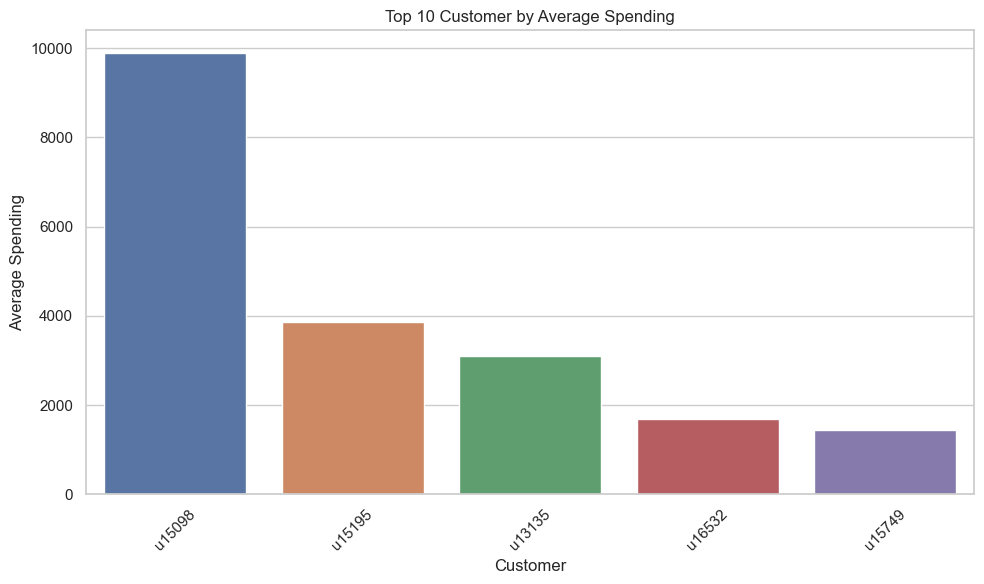

In [14]:
# To set the style for the plot 
sns.set(style="whitegrid")

# Create Barplot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
barplot = sns.barplot(x='customer_id', y='avg_spend', data=customer_spend.head())

# Set plot labels and title
plt.xlabel('Customer')
plt.ylabel('Average Spending')
plt.title('Top 10 Customer by Average Spending')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the 
plt.tight_layout()
plt.show()

##### Above plots helps to identiy Top 10 customers are from UK in terms of average spending 

#### Distribution of Invoices as per month,year and day
- Visualize the distribution of Invoices per month?
- Which month has the highest number of transactions?
- Which day of the week has the highest number of transactions?

- Option 1 :- Extract SQL query invoices per month

In [15]:
query='''
select extract (month from invoice_date) as month, 
       count(distinct invoice) as invoice_count
from bootcamp.online_transactions_cleaned
where extract (year from invoice_date) = 2011
group by month
order by invoice_count desc;
'''
pd.read_sql(query,connect)

,month,invoice_count
0,11,3034
1,10,2208
2,9,2038
3,5,1808
4,6,1686
5,3,1588
6,7,1555
7,8,1506
8,4,1358
9,1,1225


#### In the year 2011 highest number of invoices are done in the month of November

- Option 2 :- Extract invoice month using datetime function on invoice_date

In [16]:
online_transactions_cleaned['invoice_month']= online_transactions_cleaned['invoice_date'].dt.month
online_transactions_cleaned.head()

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country,invoice_month
0,536384,22189,CREAM HEART CARD HOLDER,3.95,4,15.8,2010-12-01 09:53:00,u18074,United Kingdom,12
1,536392,21891,TRADITIONAL WOODEN SKIPPING ROPE,1.25,12,15.0,2010-12-01 10:29:00,u13705,United Kingdom,12
2,536401,22068,BLACK PIRATE TREASURE CHEST,1.65,2,3.3,2010-12-01 11:21:00,u15862,United Kingdom,12
3,536412,22961,JAM MAKING SET PRINTED,1.45,24,34.8,2010-12-01 11:49:00,u1792,United Kingdom,12
4,536420,21889,WOODEN BOX OF DOMINOES,1.25,12,15.0,2010-12-01 12:03:00,u16583,United Kingdom,12


#### Invoices extracted as per invoice month highest number of invoices are made during festive season month which is December in the year 2010

- To check invoices made monthly distribution

In [17]:
monthly_distribution =online_transactions_cleaned.groupby('invoice')['invoice_month'].value_counts().sort_values(ascending=False).reset_index(name= 'Invoice per month')
monthly_distribution.head()

,invoice,invoice_month,Invoice per month
0,576339,11,542
1,579196,11,533
2,580727,12,529
3,578270,11,442
4,573576,10,435


#### November month highest number of invoices transaction recorded 

- Option 1 :- Extract Day of week using datetime function

In [18]:
online_transactions_cleaned['dow']= online_transactions_cleaned['invoice_date'].dt.day
online_transactions_cleaned.head()

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country,invoice_month,dow
0,536384,22189,CREAM HEART CARD HOLDER,3.95,4,15.8,2010-12-01 09:53:00,u18074,United Kingdom,12,1
1,536392,21891,TRADITIONAL WOODEN SKIPPING ROPE,1.25,12,15.0,2010-12-01 10:29:00,u13705,United Kingdom,12,1
2,536401,22068,BLACK PIRATE TREASURE CHEST,1.65,2,3.3,2010-12-01 11:21:00,u15862,United Kingdom,12,1
3,536412,22961,JAM MAKING SET PRINTED,1.45,24,34.8,2010-12-01 11:49:00,u1792,United Kingdom,12,1
4,536420,21889,WOODEN BOX OF DOMINOES,1.25,12,15.0,2010-12-01 12:03:00,u16583,United Kingdom,12,1


#### 1st day of week most transactions taken place

- Option 2 :- SQL query to understand which day makes maximum transactions in year 2011 

In [19]:
query='''
select extract (DOW from invoice_date) as day_of_week, 
       count(distinct invoice) as transaction_count
from bootcamp.online_transactions_cleaned
where extract(year from invoice_date) = 2011
group by day_of_week
order by  transaction_count desc
limit 1;
'''
pd.read_sql(query,connect)

,day_of_week,transaction_count
0,4,4430


#### In the year 2011, every 4th day of week highest transaction recorded

- Option 3 :- SQL query extract year 2010  to to understand which day makes maximum transactions

In [20]:
query='''
select extract (DOW from invoice_date) as day_of_week, 
       count(distinct invoice) as transaction_count
from bootcamp.online_transactions_cleaned
where extract(year from invoice_date) = 2010
group by day_of_week
order by  transaction_count desc
limit 1;
'''
pd.read_sql(query,connect)

,day_of_week,transaction_count
0,4,458


### In the year 2010 as well every 4th DOW has made maximum transactions we can assume it maybe festival day

#### Which customers could be considered high profile customers?
- Identify customers that have spent more than the average user
- Which customers have purchased the most (look at the frequency of orders)?
- Can you say anything about customers that purchased recently?


In [21]:
# To check how many invoices  quantity are in negative value 
online_transactions_cleaned[(online_transactions_cleaned.quantity < 0)].head(10)

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country,invoice_month,dow
60,C536548,22580,ADVENT CALENDAR GINGHAM SACK,5.95,-4,-23.80,2010-12-01 14:33:00,u12472,Germany,12,1
139,C536820,22878,Unknown,2.10,-1,-2.10,2010-12-02 17:14:00,u18168,United Kingdom,12,2
150,C536548,21218,RED SPOTTY BISCUIT TIN,3.75,-3,-11.25,2010-12-01 14:33:00,u12472,Germany,12,1
205,C536850,22942,CHRISTMAS LIGHTS 10 SANTAS,7.65,-48,-367.20,2010-12-03 09:47:00,u14213,United Kingdom,12,3
252,C536807,22501,PICNIC BASKET WICKER LARGE,9.95,-2,-19.90,2010-12-02 16:45:00,u15834,United Kingdom,12,2
269,C536812,22595,CHRISTMAS GINGHAM HEART,0.72,-144,-103.68,2010-12-02 16:58:00,u16546,United Kingdom,12,2
384,C536822,21430,SET/3 RED GINGHAM ROSE STORAGE BOX,3.75,-1,-3.75,2010-12-02 17:19:00,u14625,United Kingdom,12,2
420,C536854,22158,3 HEARTS HANGING DECORATION RUSTIC,2.95,-1,-2.95,2010-12-03 10:09:00,u1524,United Kingdom,12,3
424,C537383,21658,GLASS BEURRE DISH,3.95,-1,-3.95,2010-12-06 13:17:00,u1655,United Kingdom,12,6
450,C537132,22788,BROCANTE COAT RACK,8.50,-2,-17.00,2010-12-05 12:29:00,u15221,United Kingdom,12,5


#### There are Invoices with C before some invoice numbers for every negative value in the quantity column, this could mean that the order has been cancelled by customer

In [22]:
# To crosscheck customer_id = u16546 made how many transactions made by him and cancelled
online_transactions_cleaned[(online_transactions_cleaned.customer_id == "u16546")]

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country,invoice_month,dow
269,C536812,22595,CHRISTMAS GINGHAM HEART,0.72,-144,-103.68,2010-12-02 16:58:00,u16546,United Kingdom,12,2
1938,536663,22952,60 CAKE CASES VINTAGE CHRISTMAS,0.55,24,13.20,2010-12-02 12:07:00,u16546,United Kingdom,12,2
2457,536663,22737,RIBBON REEL CHRISTMAS PRESENT,1.65,20,33.00,2010-12-02 12:07:00,u16546,United Kingdom,12,2
2553,C536812,22130,PARTY CONE CHRISTMAS DECORATION,0.72,-144,-103.68,2010-12-02 16:58:00,u16546,United Kingdom,12,2
8389,C536812,22578,WOODEN STAR CHRISTMAS SCANDINAVIAN,0.85,-36,-30.60,2010-12-02 16:58:00,u16546,United Kingdom,12,2
8820,536663,22632,HAND WARMER RED POLKA DOT,2.10,24,50.40,2010-12-02 12:07:00,u16546,United Kingdom,12,2
9105,536663,22867,HAND WARMER BIRD DESIGN,2.10,24,50.40,2010-12-02 12:07:00,u16546,United Kingdom,12,2
9784,C536812,22588,CARD HOLDER GINGHAM HEART,2.10,-192,-403.20,2010-12-02 16:58:00,u16546,United Kingdom,12,2
10302,536663,22910,PAPER CHAIN KIT VINTAGE CHRISTMAS,2.55,40,102.00,2010-12-02 12:07:00,u16546,United Kingdom,12,2
10311,536663,22633,HAND WARMER UNION JACK,2.10,24,50.40,2010-12-02 12:07:00,u16546,United Kingdom,12,2


#### Extract Data from online_transaction_cleaned using below input for further analysis to workout high profile customer and recent purchases made
- extracts data from redshift
- querying the table online_transactions_cleaned from bootcamp data warehouse
- create variable as transactions_count from distinct invoices
-create variable as product_count from distinct stock code
-extract max invoice date as recent purchase made
- average  total order value rounded to 2
- extract year from invoice_date as 2011
- having order value greater than 0 to remove cancellation invoices

In [23]:
def extract_customer_data(dbname,host,port,user,password):
    
    
    connect = connect_to_redshift(dbname, host, port, user, password)

    query = """
    select customer_id,
           country,
           description,
           stock_code,
           count(distinct invoice) as transaction_count,
           count(distinct stock_code) as product_count,
           max(invoice_date) as recent_purchase_made,
           round(avg(total_order_value),2) as avg_order_value
    from bootcamp.online_transactions_cleaned 
    where extract(year from invoice_date) = '2011' 
    group by customer_id,country,description,stock_code
    having avg_order_value > 0
    order by avg_order_value desc;
    """
    online_trans_cleaned =pd.read_sql(query,connect)
   

    return online_trans_cleaned

 



In [24]:
# Assigned variable name to create dataframe
customer_data=extract_customer_data(dbname,host,port,user,password)
customer_data.info()

connection to redshift made
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250042 entries, 0 to 250041
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   customer_id           250042 non-null  object        
 1   country               250042 non-null  object        
 2   description           250042 non-null  object        
 3   stock_code            250042 non-null  object        
 4   transaction_count     250042 non-null  int64         
 5   product_count         250042 non-null  int64         
 6   recent_purchase_made  250042 non-null  datetime64[ns]
 7   avg_order_value       250042 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 15.3+ MB


##### Check the shape of Extracted dataframe 

In [25]:
customer_data.shape

(250042, 8)

##### Top five customers based on Average Order value spending pattern 

In [26]:
customer_data.head()

,customer_id,country,description,stock_code,transaction_count,product_count,recent_purchase_made,avg_order_value
0,u15098,United Kingdom,PICNIC BASKET WICKER SMALL,22502,4,1,2011-06-10 15:39:00,9904.88
1,u15195,United Kingdom,METAL SIGN TAKE IT OR LEAVE IT,22413,1,1,2011-12-07 12:20:00,3861.00
2,u17949,United Kingdom,REGENCY TEAPOT ROSES,23173,2,1,2011-07-28 14:33:00,3765.30
3,u18102,United Kingdom,LANDMARK FRAME NOTTING HILL,23555,1,1,2011-10-21 12:08:00,3285.00
4,u18102,United Kingdom,LANDMARK FRAME OXFORD STREET,23554,1,1,2011-10-21 12:08:00,3285.00


- Which customers have spent the least amount? What should the company do about such customers?

In [27]:
customer_data.tail()

,customer_id,country,description,stock_code,transaction_count,product_count,recent_purchase_made,avg_order_value
250037,u17571,United Kingdom,TEATIME ROUND PENCIL SHARPENER,16048,1,1,2011-10-20 15:57:00,0.12
250038,u1592,United Kingdom,PORCELAIN BUDAH INCENSE HOLDER,17038,1,1,2011-07-08 15:25:00,0.10
250039,u14104,United Kingdom,PORCELAIN BUDAH INCENSE HOLDER,17038,1,1,2011-06-27 12:49:00,0.10
250040,u15858,United Kingdom,PORCELAIN BUDAH INCENSE HOLDER,17038,1,1,2011-11-24 12:48:00,0.10
250041,u14866,United Kingdom,PAPER POCKET TRAVELING FAN,15034,3,1,2011-09-27 11:08:00,0.05


#### Customer who has spent least amount are from UK 
- Before taking any action need to segment customer and analyze purchasing behavior pattern using RFM analysis
- Then plan retention strategy run some marketing campagin 

# Transforming Data

## RFM Analaysis

Recency-Frequency-Monetary (RFM) analysis is a indexing technique that uses past purchase behavior to segment customers into groups

- Recency: How recently have they made a purchase?- Frequency: How often have they bought something?
- 
Monetary Value: How much money do they spend on average when making purchases?

## Define scoring criteria for each RFM value

recency_scores = [5, 4, 3, 2, 1]  #  5 to 1 Higher score for lower recency (most recent purchase made by customer)

frequency_scores = [1, 2, 3, 4,5]  # 1 to 5 Higher score for higher frequency (customers who made more frequent purchases will receive higher frequencyscores)

monetary_scores = [1, 2, 3, 4, 5]  #  1 to 5 Higher score for higher monetary value (higher amount spent by the customer)

## Value Segmetation using RFM score 
- RFM score by Adding individual Receny,frequeny and Monetary scores
- Using pd-qcut function created segment labels assinged 3 bins as low-value, mid-value, high-value

## Describe RFM Customer Segment
 To provide a more strategic perspective on customer behaviour and characteristics in terms of recency, frequency, and monetary aspects. 
#### Classify RFM customer Segment as below :-
##### Champions customers :
Are most valuable and successful customers ,they contribute significatnly to company revenue and are loyal to brand and services. 
##### Loyal customers :
Loyal customers have shown strong interest in products or services.Loyal ustomers are essential for building stable customer base.
#####  Speculative Customers:
Are those who are currently considering other brand. products or services risk of losing such customer is high offering them competitive prices and addressing their concerns help to prevent them from switching.
##### Churned customers :
Who were once engaged and valuable customers but have disengaged or stopped making purchase company can make such reactivation campaigns and offers to retain them.


In [28]:
def calculate_rfm_and_segment(df):

    if 'recent_purchase_made' in df.columns:
        df["recency"] = round((df['recent_purchase_made'].max() - df['recent_purchase_made']) / np.timedelta64(1, 'D'),0)

    if 'stock_code' in df.columns:
        # Calculate frequency: how often a customer has bought products
        frequency_data = df.groupby('customer_id')['stock_code'].count().reset_index()
        # Rename stock_code column as frequency
        frequency_data.rename(columns={'stock_code': 'frequency'}, inplace=True)
        # Merge left join using customer_id common column
        customer_freq_data = df.merge(frequency_data, on='customer_id', how='left')

    if 'avg_order_value' in df.columns:
        # Calculate monetary_value : how much on average customer spends
        monetary_data = df.groupby('customer_id')['avg_order_value'].sum().reset_index()
        # Rename Average_order_value column as monetary_value
        monetary_data.rename(columns={'avg_order_value': 'monetary_value'}, inplace=True)
        # Merge left join customer_freq_data using customer_id common column
        df = customer_freq_data.merge(monetary_data, on='customer_id', how='left')

        # Using pd.qcut function assigning 4 bins calculate rfm score
        # Calculate rec_score
        df['rec_score'] = pd.qcut(df['recency'], 4, ['4', '3', '2', '1']).astype(int)
        # Calculate freq_score
        df['freq_score'] = pd.qcut(df['frequency'], 4, ['4', '3', '2', '1']).astype(int)
        # Calculate mone_score
        df['mone_score'] = pd.qcut(df['monetary_value'], 4,['4', '3', '2', '1']).astype(int)
        # Add rec_score,freq_score,mone_score to form rfm_score
        df['rfm_score'] = df['rec_score'] + df['freq_score'] + df['mone_score']

        # Create Segment _labels as low_value,mid_value & high_value
        segment_labels = ['low-value', 'mid-value', 'high-value']
        # Using pd.qcut function assigned 3 bins to create value_segments
        df['value_segment'] = pd.qcut(df['rfm_score'], q=3, labels=segment_labels)

        # Create new column rfm_customer_segments
        df['rfm_customer_segments'] = ''
        # Assigned rfm_customer_segments by distribution of rfm_score
        df.loc[(df['rfm_score'] >= 9) & (df['rfm_score'] < 13), 'rfm_customer_segments'] = 'Champions'
        df.loc[(df['rfm_score'] >= 7) & (df['rfm_score'] < 9), 'rfm_customer_segments'] = 'Loyal'
        df.loc[(df['rfm_score'] >= 5) & (df['rfm_score'] < 7), 'rfm_customer_segments'] = 'Speculative'
        df.loc[(df['rfm_score'] >= 3) & (df['rfm_score'] < 5), 'rfm_customer_segments'] = 'Churned'

        return df


In [29]:
# Assigned variable name
customer_data = calculate_rfm_and_segment(customer_data)
customer_data.head()

,customer_id,country,description,stock_code,transaction_count,product_count,recent_purchase_made,avg_order_value,recency,frequency,monetary_value,rec_score,freq_score,mone_score,rfm_score,value_segment,rfm_customer_segments
0,u15098,United Kingdom,PICNIC BASKET WICKER SMALL,22502,4,1,2011-06-10 15:39:00,9904.88,182.0,1,9904.88,2,4,1,7,mid-value,Loyal
1,u15195,United Kingdom,METAL SIGN TAKE IT OR LEAVE IT,22413,1,1,2011-12-07 12:20:00,3861.00,2.0,1,3861.00,4,4,1,9,mid-value,Champions
2,u17949,United Kingdom,REGENCY TEAPOT ROSES,23173,2,1,2011-07-28 14:33:00,3765.30,134.0,27,20098.88,2,4,1,7,mid-value,Loyal
3,u18102,United Kingdom,LANDMARK FRAME NOTTING HILL,23555,1,1,2011-10-21 12:08:00,3285.00,49.0,145,80559.18,3,2,1,6,low-value,Speculative
4,u18102,United Kingdom,LANDMARK FRAME OXFORD STREET,23554,1,1,2011-10-21 12:08:00,3285.00,49.0,145,80559.18,3,2,1,6,low-value,Speculative


 Then we should see new columns created rfm score ,value segment & rfm_customer_segments which helps to understand segmentation in terms of score and value  customers who are most valualble loyal to business.

- RFM value segment represents the categorization of customers based on their RFM scores into groups such as “low value”, “medium value”, and “high value”.
- These segments are determined by dividing RFM scores into distinct ranges or groups, allowing for a more granular analysis of overall customer RFM characteristics.
- The RFM value segment helps us to understand the relative value of customers in terms of recency, frequency, and moneta

# Data Visualization

- Barplot to display RFM value segment distribution
- Using Treemap to showcase value segment visualization low-value,mid-value nad high-value
- Heatmap visualization
- Plot rfm cusomter segments selecting one segment
- Coorelation matrix for championsegment of RFM values
- Plotly Plot comparison of RFM segments
- Comparison of RFM segment based on recency,freqency and monetory score

In [30]:
# Assinged varibale name as segment_counts to plot segmentation
segment_counts = customer_data['value_segment'].value_counts().reset_index()
# dataframe segment_counts 
segment_counts.columns = ['value_segment', 'count']

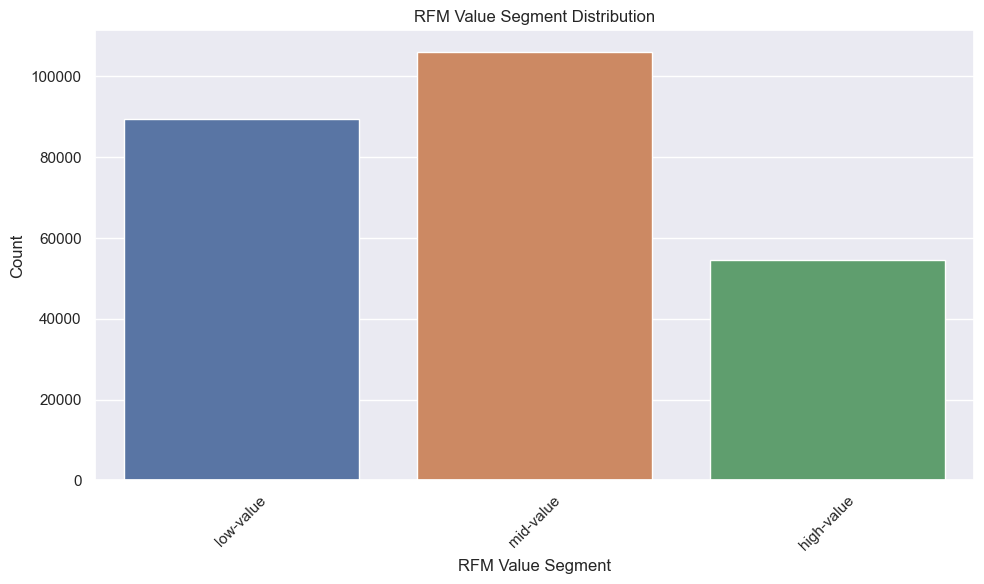

In [31]:
# To set the style for the plot 
sns.set(style="darkgrid")

# Create Barplot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
barplot = sns.barplot(x='value_segment', y='count', data=segment_counts)

# Set plot labels and title
plt.xlabel('RFM Value Segment')
plt.ylabel('Count')
plt.title('RFM Value Segment Distribution')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the 
plt.tight_layout()
plt.show()

Above bar plot allows you to see how customers are distributed among different RFM Value Segments.
Mid-value segment has highest count compared to high -value and low-value segment which indicates business need to plan marketing stratgies to retain more customers in high -value and reconsider re-engagement acitivites more marketing efforts for low -value segment customer 

In [32]:
segment_product_counts = customer_data.groupby(['value_segment', 'rfm_customer_segments']).size().reset_index(name='count')
segment_product_counts.columns

Index(['value_segment', 'rfm_customer_segments', 'count'], dtype='object')

In [33]:
segment_product_counts.head()

,value_segment,rfm_customer_segments,count
0,low-value,Champions,0
1,low-value,Churned,27391
2,low-value,Loyal,0
3,low-value,Speculative,61985
4,mid-value,Champions,37004


##### Treemap plot using Plotly to visualize the distribution of customers across different customer segments, classified by both their RFM Value Segments (High Value, Mid Value, Low Value) and their specific RFM Customer Segments (e.g., Champions, Loyal, Speculative, Churned). 

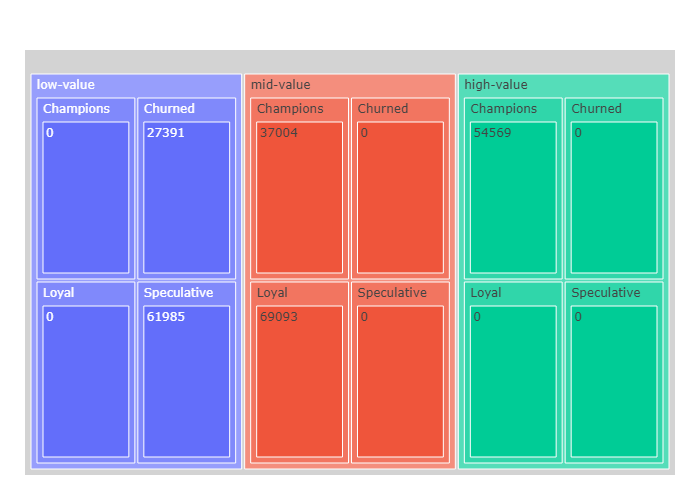

In [34]:
# Template selection
pio.templates.default = "plotly_white"
# Path to determine hirearchical structure
fig = px.treemap(segment_product_counts, path=['value_segment', 'rfm_customer_segments', 'count']) #
# Color coding
fig.update_traces(root_color="lightgrey")
# Update_layout is used to set margins around the treemap to ensure proper spacing.
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

# Save the treemap image
img_bytes = pio.to_image(fig, format="png")  
# Display the image
Image(img_bytes)


- RFM Value Segments (Outer Rectangles): The outermost rectangles represent the RFM Value Segments, which classify customers into High Value, Mid Value, and Low Value based on their RFM scores. These segments provide a broad categorization of customer value.

- RFM Customer Segments (Inner Rectangles): Within each RFM Value Segment, the treemap is divided into smaller rectangles, representing the specific RFM Customer Segments. For example, within the "High Value" segment, you can see how customers are further classified as Champions, Loyal, Speculative, or Churned.

- Size of Rectangles: The size of each rectangle (node) within the treemap is proportional to the count of customers in that segment. Larger rectangles indicate a higher number of customers, while smaller rectangles represent fewer customers.

- Hierarchy: The hierarchical structure allows you to explore how customer segments are distributed within each RFM Value Segment. For instance, you can see which RFM Customer Segments are predominant within the "High Value" segment.

- Insights: The treemap plot helps you gain insights into the composition of your customer base. You can identify which RFM Value Segments have the highest customer counts and which specific RFM Customer Segments are more prevalent within each Value Segment.

- Targeting and Strategy: This visualization can guide marketing and engagement strategies. For example, you might want to focus on retaining "Champions" within the "High Value" segment or re-engage "Churned" customers in the "Low Value" segment.

- Overall, the treemap plot provides a visual summary of customer segmentation based on both RFM Value Segments and RFM Customer Segments, enabling you to make data-driven decisions to optimize marketing and customer engagement efforts.

##### Option 2 - Using Heatmap distribution of customers across value segment & rfm customer segments

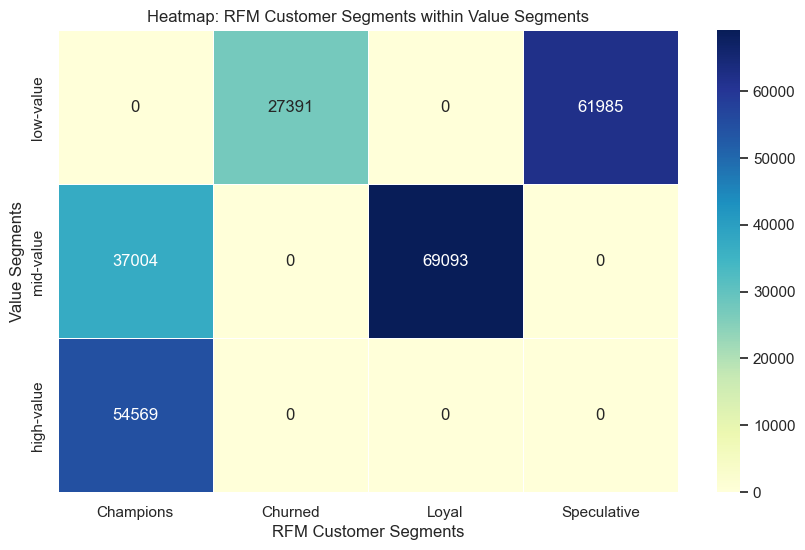

In [35]:
# Creat Pivot_table
pivot_table = segment_product_counts.pivot(index='value_segment', columns='rfm_customer_segments', values='count')

# Select the size
plt.figure(figsize=(10, 6))

# Create a heatmap using Seaborn
sns.heatmap(data=pivot_table, cmap='YlGnBu', annot=True, fmt='d', linewidths=0.5)

# Add title and labels
plt.title('Heatmap: RFM Customer Segments within Value Segments')
plt.xlabel('RFM Customer Segments')
plt.ylabel('Value Segments')

plt.show()


- Color Intensity: Darker colors (shades of blue) indicate higher customer counts, while lighter colors (shades of yellow) represent lower counts.

- High Value Segments: In the "High Value" segment, you can observe how customers are distributed across the RFM Customer Segments. For instance, you can see which RFM Customer Segment has the highest count within the "High Value" category.

- Mid Value and Low Value Segments: Similarly, you can analyze the distribution of customers in the "Mid Value" and "Low Value" segments. This allows you to identify the predominant RFM Customer Segments within each Value Segment.

-  Comparisons: You can compare the distribution of customers across different Value Segments and Customer Segments. For example, you can assess whether certain Customer Segments are more prevalent in specific Value Segments.

- Insights for Targeting: This heatmap provides insights that can guide targeting and marketing strategies. For instance, you might want to focus marketing efforts on retaining or re-engaging specific Customer Segments within different Value Segments.

- Data-Driven Decisions: The heatmap allows you to make data-driven decisions by visualizing the customer distribution and identifying areas of focus for marketing campaigns, customer retention efforts, and product/service offerings.

##### Box plot that visualizes the distribution of RFM (Recency, Frequency, Monetary) values within the "Champions" customer segment.

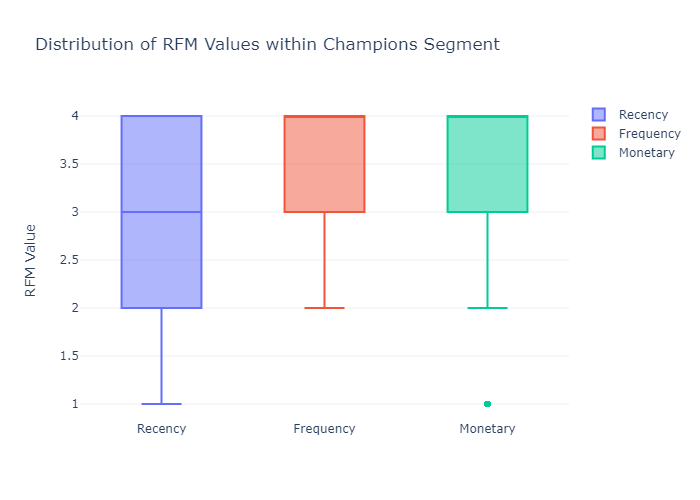

In [36]:
champions_segment = customer_data[customer_data['rfm_customer_segments'] == 'Champions']

fig = go.Figure()
# X axis shows three categories: Recency, Frequency, and Monetary
# Y axis represents RFM values themselves 'rec_score,'freq_score,' and 'mone_score'
fig.add_trace(go.Box(y=champions_segment['rec_score'], name='Recency'))
fig.add_trace(go.Box(y=champions_segment['freq_score'], name='Frequency'))
fig.add_trace(go.Box(y=champions_segment['mone_score'], name='Monetary'))

# Box plot displays the IQR of the respective RFM value

fig.update_layout(title='Distribution of RFM Values within Champions Segment',
                  yaxis_title='RFM Value',
                  showlegend=True)

# Save the figure as an image
img_bytes = pio.to_image(fig, format="png")

# Display the image in the notebook
Image(img_bytes)

- Recency : Box plot for recency shows that majority of customers in this segment have relatively low scores meaning they have made recent purchases.Lower quartile Q1 is closer to minimum score indicate many customers have very recent transactions.
- Frequency : Box plot for frequency shows that most cusotmers have a relatively high frequency of purchases.Majority of customers fall within a narrow range of frequncy scores and very few outlier on lower side ,suggest a small number of customers who make purchases less frequently.
- Monetary : Box plot for monetary shows that customers spends more on average.IQR is relatively tight ,indicates consistency in spending .
However, there are some variations within the segment, including small number of customers with less recent purcahses,lower frequency or lower spending.
These insight is valuable for making tailor made marketing and engagement campagins to encourage more frequent and high-value purchases or addressing the needs of customers who fall into outlier category to ehance more engagement & loyalty activites.

##### Option 2-Correlation matrix of RFM values within "Champions"customer segment

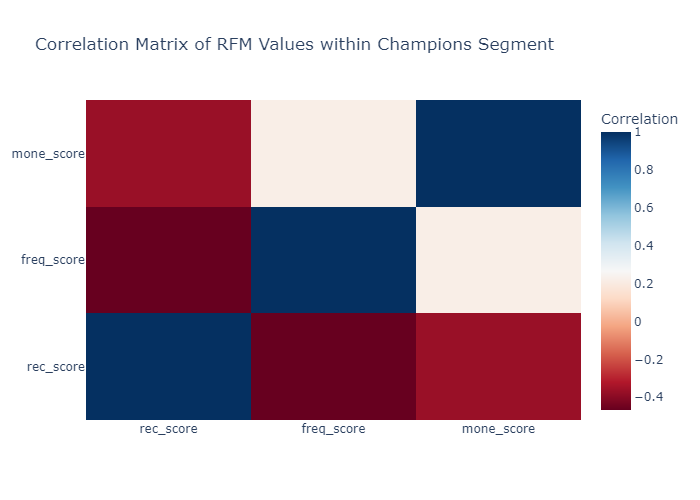

In [37]:
correlation_matrix = champions_segment[['rec_score', 'freq_score', 'mone_score']].corr()

# Visualize the correlation matrix using a heatmap
fig_heatmap = go.Figure(data=go.Heatmap(
                   z=correlation_matrix.values,
                   x=correlation_matrix.columns,
                   y=correlation_matrix.columns,
                   colorscale='RdBu',
                   colorbar=dict(title='Correlation')))

fig_heatmap.update_layout(title='Correlation Matrix of RFM Values within Champions Segment')

# Save the heatmap as an image
img_bytes = pio.to_image(fig_heatmap, format="png")  # Change 'fig' to 'fig_heatmap'
# Displa the image
Image(img_bytes)

- Recency vs Frequency : Cell is slightly showing negative(red color) indicate weak negative correlation .It means customers who have made more frequent purcahses tend to have lower recency scores -which means they have made purchases more recently.
- Recency vs Monetary : Cell is showing slightly negative (orange) indicating weak negative correlation which means customers who have made more recent purchases tend to have slightly lower monetary value.
- Frequency vs Monetary: Cell is (pastel red) indicating positive correlation between frequency and monetary value which means that customers who make more frequent purchasse tend to have higher monetary values.
This information can be useful for understanding how these RFM metrics relate to each other within the "Champions" segment and can inform marketing and engagement strategies. For example, it may be beneficial to target customers with lower recency to encourage more frequent and higher-value purchases.

##### Bar chart to compare counts of customer in different RFM segments 

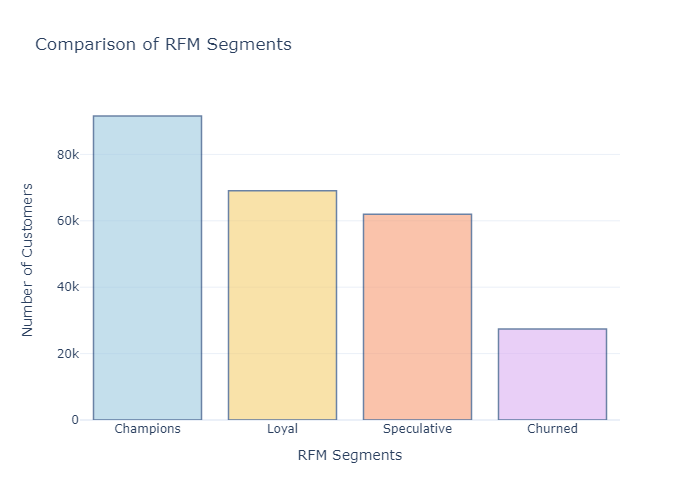

In [38]:
pastel_colors = plotly.colors.qualitative.Pastel

segment_counts = customer_data['rfm_customer_segments'].value_counts()

# Create a bar chart to compare segment counts
fig = go.Figure(data=[go.Bar(x=segment_counts.index, y=segment_counts.values,
                            marker=dict(color=pastel_colors))])

# Set the color of the Champions segment as a different color
champions_color = 'rgb(158, 202, 225)'
fig.update_traces(marker_color=[champions_color if segment == 'Champions' else pastel_colors[i]
                                for i, segment in enumerate(segment_counts.index)],
                  marker_line_color='rgb(8, 48, 107)',
                  marker_line_width=1.5, opacity=0.6)

# Update the layout
fig.update_layout(title='Comparison of RFM Segments',
                  xaxis_title='RFM Segments',
                  yaxis_title='Number of Customers',
                  showlegend=False)

# Save the figure as an image
img_bytes = pio.to_image(fig, format="png")

# Display the image
Image(img_bytes)

- The "Champions" segment likely contains a higher number of customers compared to other segments, as it is often a goal to have a substantial number of loyal and high-value customers.
- Other segments such as "Loyal," "Speculative," and "Churned" may have varying customer counts, reflecting different levels of engagement and value.
- The chart provides insights into the distribution of customers based on their RFM scores and can inform targeted marketing efforts and customer relationship management strategies.
- For example, the company may want to focus on retaining and rewarding "Champions" while implementing different strategies for customers in other segments to move them towards becoming more loyal and higher-value customers

##### Option 2 : Pie chart distribution of customer count across RFM segments

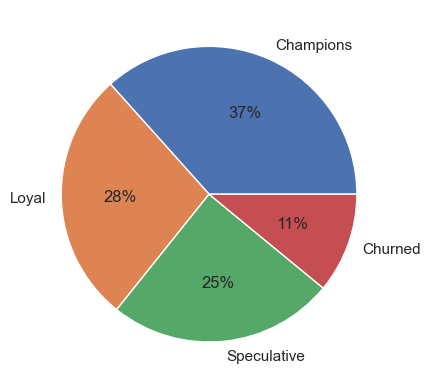

In [39]:
# Pie chart to check which segment has high % of customers
plt.pie(customer_data.rfm_customer_segments.value_counts(),
        labels=customer_data.rfm_customer_segments.value_counts().index,
        autopct='%.0f%%')
plt.show()

- Large portion of the pie is occupied by the 'Loyal' and 'Champions' which indicates that a significatn percentage of customers are highly engaged and valuable to the business.
- Smaller portion of pie which is 'Churned' which indicates that only lesser percentage of customers are disengaged or at risk of churning.
- The pie chart provides a clear and concise representation of the distribution of customers across RFM segments, helping businesses understand the composition of their customer base and make data-driven decisions based on customer segment proportions.

#### Grouped bar chart to compare the average Recency, Frequency and Monetary scores for each customer segment.

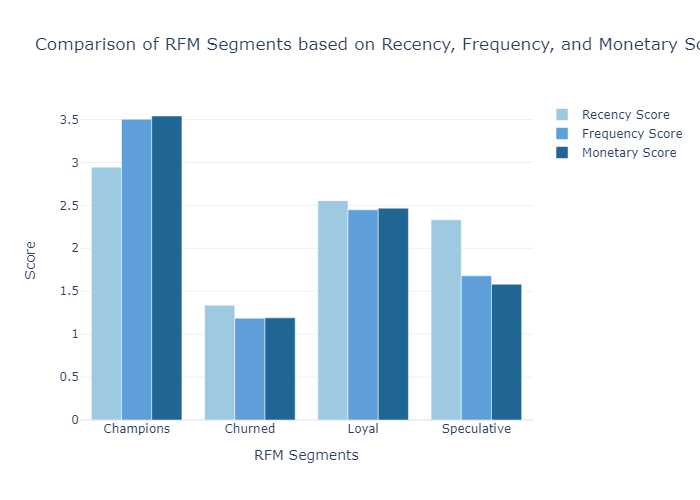

In [40]:
# Calculate the average Recency, Frequency, and Monetary scores for each segment
segment_scores = customer_data.groupby('rfm_customer_segments')[['rec_score', 'freq_score', 'mone_score']].mean().reset_index()

# Create a grouped bar chart to compare segment scores
fig = go.Figure()

# Add bars for Recency score
fig.add_trace(go.Bar(
    x=segment_scores['rfm_customer_segments'],
    y=segment_scores['rec_score'],
    name='Recency Score',
    marker_color='rgb(158,202,225)'
))

# Add bars for Frequency score
fig.add_trace(go.Bar(
    x=segment_scores['rfm_customer_segments'],
    y=segment_scores['freq_score'],
    name='Frequency Score',
    marker_color='rgb(94,158,217)'
))

# Add bars for Monetary score
fig.add_trace(go.Bar(
    x=segment_scores['rfm_customer_segments'],
    y=segment_scores['mone_score'],
    name='Monetary Score',
    marker_color='rgb(32,102,148)'
))

# Update the layout
fig.update_layout(
    title='Comparison of RFM Segments based on Recency, Frequency, and Monetary Scores',
    xaxis_title='RFM Segments',
    yaxis_title='Score',
    barmode='group',
    showlegend=True
)
# Save the figure as Image
img_bytes=pio.to_image(fig, format ="png")

# Display the image

Image(img_bytes)

- You can observe in this grouped bar chart height of each segment ,Higher the bar height which means higher the average score for that particular RFM component in that segment .
- Champions segment has highest monetary score it means these cusotmers contribute the most in terms of monetary value.
- Loyal segment has a significantly higher frequency score compared to other segment indicates that these customers make frequent purchases.
- It helps in identifying the strengths and weaknesses of each segment and qllowing business to assess segment performance and tailor strategies to meet specific segment needs and preferences.

#### Using Agg() groupby function for to showcase delivery of segmetatiion per customer based on value_segment and rfm_customer_segment

In [41]:
segment_data = customer_data.groupby(['customer_id']).agg( value_segment=('value_segment', 'first'),rfm_customer_segments=('rfm_customer_segments', 'first'),rfm_score =('rfm_score','first')).reset_index()
segment_data.head()

,customer_id,value_segment,rfm_customer_segments,rfm_score
0,u12347,low-value,Speculative,6
1,u12348,high-value,Champions,11
2,u12349,mid-value,Champions,9
3,u1235,mid-value,Champions,9
4,u12352,mid-value,Loyal,7


From original customer data is used for groupby 'customer_id', and for each customer, it selects the first value of 'value_segment', 'rfm_customer_segments', and 'rfm_score'. This is useful for summarizing the segmentation information for each customer in a more compact form which helps business to know particular one customer falls in one row with rfm segement which will be gives more insights to form marketing strategy.

## Loading data to local folder

In [42]:
# Load Segment_data dataframe to csv file
segment_data.to_csv("../data/customer_segmentation_data.csv")

In [43]:
# Assigned variable name
test=pd.read_csv("../data/customer_segmentation_data.csv")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4201 entries, 0 to 4200
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0             4201 non-null   int64 
 1   customer_id            4201 non-null   object
 2   value_segment          4201 non-null   object
 3   rfm_customer_segments  4201 non-null   object
 4   rfm_score              4201 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 164.2+ KB
